# Part 3: Report Analysis

This notebook conatians the Part 3 reports for the analysis or Rearc quest

In Part 3, the goal is to load datasets produced in Part 1 (BLS time-series data) and Part 2 (Population API data) and perform analytics to extract meaningful insights.

The analysis is implemented using Pandas DataFrames which includes

- Data cleaning and normalization

- Aggregations across time

- Joining heterogeneous datasets

- Producing repeatable, verifiable results

In [1]:
#importing....

import os
import io
import json
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



### Reading data from S3 using `S3_BUCKET` and the S3 keys created in Parts 1–2.

In [2]:
S3_BUCKET = os.getenv("S3_BUCKET", "rearc-bls-republish-2026")

S3_BUCKET
# Part 1 output (update this key to your actual S3 key)
PR_CURRENT_KEY = os.getenv("PR_CURRENT_KEY", "bls/pr/pr.data.0.Current")

# Part 2 output (update if different)
POP_JSON_KEY = os.getenv("POP_JSON_KEY", "bls/api/population.json")

s3 = boto3.client("s3")

# PR_CURRENT_KEY
# POP_JSON_KEY


In [3]:
def s3_read_bytes(bucket: str, key: str) -> bytes:
    obj = s3.get_object(Bucket=bucket, Key=key)
    return obj["Body"].read()

## Load Part 1 (BLS time series)

We load `pr.data.0.Current` from S3 into a dataframe and cleaning it:
- normalize column names (BLS sometimes has whitespace)
- trim strings
- convert `year` and `value` to numeric
- keep only quarterly periods `Q01`–`Q04`

In [4]:
# ---------- LOAD PART 1 CSV ----------
csv_bytes = s3_read_bytes(S3_BUCKET, PR_CURRENT_KEY)

# BLS files are usually tab-delimited; if yours is comma-delimited, change sep=","
df_ts = pd.read_csv(io.BytesIO(csv_bytes), sep="\t", dtype=str)
df_ts.head()

,series_id,year,period,value,footnote_codes
0,PRS30006011,1995,Q01,2.6,NaN
1,PRS30006011,1995,Q02,2.1,NaN
2,PRS30006011,1995,Q03,0.9,NaN
3,PRS30006011,1995,Q04,0.1,NaN
4,PRS30006011,1995,Q05,1.4,NaN


In [5]:
# HARD normalize column names (this fixes the BLS whitespace issue)
df_ts.columns = df_ts.columns.str.strip().str.lower()

print("Fixed columns:", df_ts.columns.tolist())


Fixed columns: ['series_id', 'year', 'period', 'value', 'footnote_codes']


In [6]:
# Trim whitespace for ALL string columns (super important for BLS datasets)
for c in df_ts.columns:
    if df_ts[c].dtype == "object":
        df_ts[c] = df_ts[c].astype(str).str.strip()

# Ensure expected columns exist
expected_cols = {"series_id", "year", "period", "value"}
missing = expected_cols - set(df_ts.columns)
if missing:
    raise ValueError(f"Missing expected columns in time-series df: {missing}")

# Convert types
df_ts["year"] = pd.to_numeric(df_ts["year"], errors="coerce").astype("Int64")

# Value sometimes has blanks or non-numeric
df_ts["value"] = pd.to_numeric(df_ts["value"], errors="coerce")

# Keep only quarter periods (Q01-Q04) for the quarterly rollups in Part 3
df_ts_q = df_ts[df_ts["period"].str.match(r"^Q0[1-4]$")].copy()

df_ts_q.head()
print(df_ts.columns.tolist())


['series_id', 'year', 'period', 'value', 'footnote_codes']


In [7]:
print(df_ts.columns.tolist())

['series_id', 'year', 'period', 'value', 'footnote_codes']


## Load Part 2 (Population JSON)

World Bank returns a list like `[metadata, data]`.
We convert it into a dataframe with `year` and `population` (or `value`).


In [8]:
pop_bytes = s3_read_bytes(S3_BUCKET, POP_JSON_KEY)
pop_raw = json.loads(pop_bytes)

# Try to locate the records array
if isinstance(pop_raw, list):
    pop_records = pop_raw
elif isinstance(pop_raw, dict):
    # common guesses
    if "data" in pop_raw and isinstance(pop_raw["data"], list):
        pop_records = pop_raw["data"]
    elif "Results" in pop_raw and "series" in pop_raw["Results"]:
        # If it's a BLS-style response, flatten it
        # You may need to adapt depending on your API's exact format
        series = pop_raw["Results"]["series"]
        # Example flatten: each series has 'data' items with 'year' and 'value'
        pop_records = []
        for s in series:
            for row in s.get("data", []):
                pop_records.append(row)
    else:
        # fallback: find first list value in dict
        list_vals = [v for v in pop_raw.values() if isinstance(v, list)]
        if not list_vals:
            raise ValueError("Could not find list of population records in JSON.")
        pop_records = list_vals[0]
else:
    raise ValueError("Unknown JSON structure for population data.")

df_pop = pd.DataFrame(pop_records)
df_pop.head()


,Nation,Nation ID,Population,Year
0,United States,01000US,316128839.0,2013
1,United States,01000US,318857056.0,2014
2,United States,01000US,321418821.0,2015
3,United States,01000US,323127515.0,2016
4,United States,01000US,325719178.0,2017


We need at least: year and population (or value).

In [9]:
# Trim whitespace
for c in df_pop.columns:
    if df_pop[c].dtype == "object":
        df_pop[c] = df_pop[c].astype(str).str.strip()

# Normalize column names
df_pop.columns = [c.strip().lower() for c in df_pop.columns]

# Try to identify population column
# Common: "value", "population", "pop", etc.
pop_col_candidates = ["population", "pop", "value"]
pop_col = next((c for c in pop_col_candidates if c in df_pop.columns), None)
if not pop_col:
    raise ValueError(f"Could not find population column. Columns are: {df_pop.columns.tolist()}")

if "year" not in df_pop.columns:
    raise ValueError(f"Could not find 'year' column in population data. Columns are: {df_pop.columns.tolist()}")

df_pop["year"] = pd.to_numeric(df_pop["year"], errors="coerce").astype("Int64")
df_pop[pop_col] = pd.to_numeric(df_pop[pop_col], errors="coerce")

# Keep only relevant years for some tasks
df_pop_2013_2018 = df_pop[(df_pop["year"] >= 2013) & (df_pop["year"] <= 2018)].copy()
df_pop_2013_2018.head()


,nation,nation id,population,year
0,United States,01000US,316128839.0,2013
1,United States,01000US,318857056.0,2014
2,United States,01000US,321418821.0,2015
3,United States,01000US,323127515.0,2016
4,United States,01000US,325719178.0,2017



## Report 1 US population mean + std (2013–2018 inclusive)

Compute mean + standard deviation of annual population for years **2013 to 2018** (inclusive).


In [10]:
pop_mean = df_pop_2013_2018[pop_col].mean()
pop_std = df_pop_2013_2018[pop_col].std(ddof=1)  # sample std dev

pop_mean, pop_std


(322069808.0, 4158441.040908095)

In [11]:
print(f"Annual US population mean (2013–2018): {pop_mean:,.2f}")
print(f"Annual US population std  (2013–2018): {pop_std:,.2f}")


Annual US population mean (2013–2018): 322,069,808.00
Annual US population std  (2013–2018): 4,158,441.04


## Report 2  Best year per series_id

For each `series_id`, find the year where the **sum of quarterly `value`** is the largest.
Return `series_id`, `best_year`, and `summed_value`.


In [12]:
annual_sum = (
    df_ts_q
    .groupby(["series_id", "year"], dropna=False, as_index=False)["value"]
    .sum()
    .rename(columns={"value": "annual_value_sum"})
)

# For each series_id, pick the row with max annual_value_sum
idx = annual_sum.groupby("series_id")["annual_value_sum"].idxmax()
best_year_report = annual_sum.loc[idx].sort_values(["series_id"]).reset_index(drop=True)

best_year_report.head(20)


,series_id,year,annual_value_sum
0,PRS30006011,2022,16.400
1,PRS30006012,2022,13.000
2,PRS30006013,1998,564.713
3,PRS30006021,2010,14.200
4,PRS30006022,2010,8.900
5,PRS30006023,2014,402.512
6,PRS30006031,2022,16.400
7,PRS30006032,2021,13.900
8,PRS30006033,1998,561.703
9,PRS30006061,2022,27.600


## Report 3 — Join series values with population

Filter the time-series to:
- `series_id = PRS30006032`
- `period = Q01`

Then join to population by `year` (if population exists for that year).


In [13]:
target = df_ts_q[
    (df_ts_q["series_id"].str.strip() == "PRS30006032") &
    (df_ts_q["period"].str.strip() == "Q01")
].copy()

# Keep only what we need
target = target[["series_id", "year", "period", "value"]].copy()

# Prepare population join df
pop_join = df_pop[["year", pop_col]].copy().rename(columns={pop_col: "Population"})

report_3 = target.merge(pop_join, on="year", how="left").sort_values("year").reset_index(drop=True)

report_3.head(20)


,series_id,year,period,value,Population
0,PRS30006032,1995,Q01,0.0,NaN
1,PRS30006032,1996,Q01,-4.2,NaN
2,PRS30006032,1997,Q01,2.8,NaN
3,PRS30006032,1998,Q01,0.9,NaN
4,PRS30006032,1999,Q01,-4.1,NaN
5,PRS30006032,2000,Q01,0.5,NaN
6,PRS30006032,2001,Q01,-6.3,NaN
7,PRS30006032,2002,Q01,-6.6,NaN
8,PRS30006032,2003,Q01,-5.7,NaN
9,PRS30006032,2004,Q01,2.0,NaN


## Outputs

- Results for Report 1, Report 2, Report 3
- CSV exports


In [14]:
# CSV to export

best_year_report.to_csv("report_best_year_by_series.csv", index=False)
report_3.to_csv("report_prs30006032_q01_population.csv", index=False)


## Visualization:



### Histogram of best-year summed values

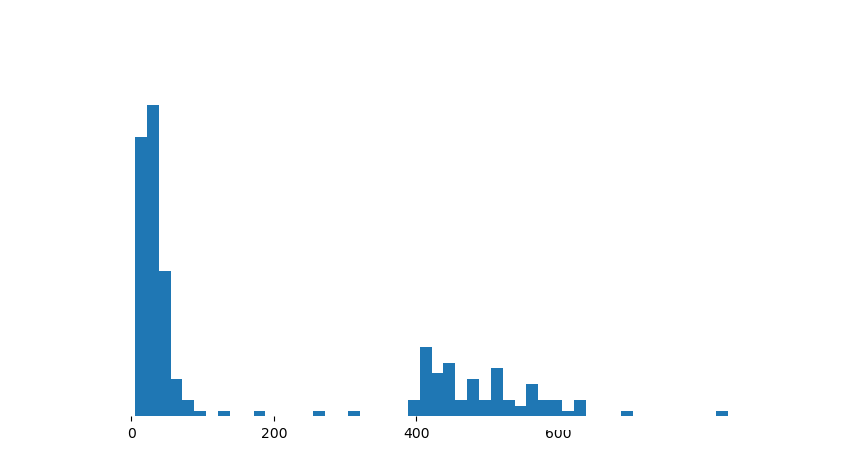

In [15]:
#plot 1
plt.figure(figsize=(10,5))
plt.hist(best_year_report["annual_value_sum"].dropna().values, bins=50)
plt.title("Distribution of best-year annual_value_sum across series")
plt.xlabel("annual_value_sum")
plt.ylabel("count of series")
plt.show()

In [16]:
### Timeseries series/period. 

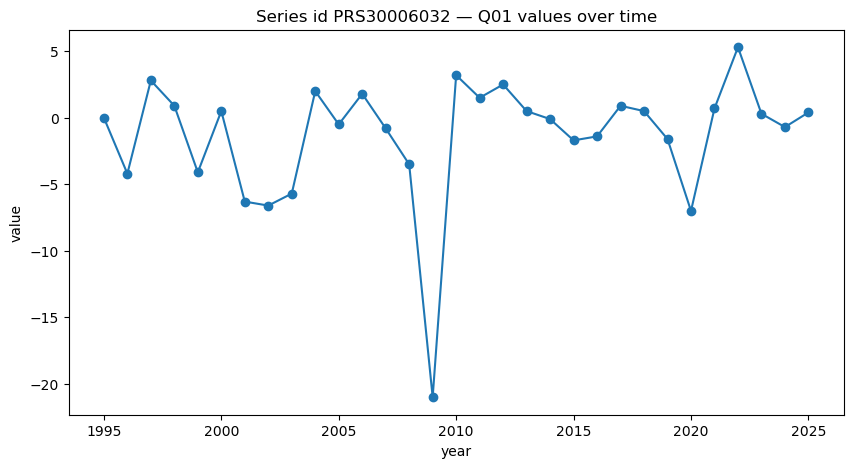

In [17]:
# sample value
SERIES_ID = "PRS30006032"
PERIOD = "Q01"

#plot 2
plt.figure(figsize=(10,5))
plt.plot(report_3["year"], report_3["value"], marker="o")
plt.title(f"Series id {SERIES_ID} — {PERIOD} values over time")
plt.xlabel("year")
plt.ylabel("value")
plt.show()